<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/01_nice_rot_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import imutils

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [3]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [4]:

class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2), nn.ReLU()) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)

        self.per_list = self.permutation()

    def forward(self, x):
        x = x.view(len(x), -1,).to(torch.float32)
        return self.f(x)

    def permutation(self):
        per_list =[]

        p = torch.eye(self.input_dim)
        for flow in range(self.num_flows):
            per_list.append(p[torch.randperm(p.size()[0])])

        return per_list

    def coupling_layer(self, x, m, flow, forward=True):

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a

        return z


    def f(self, x):
        z = x / torch.exp(self.s)

        for flow, model in enumerate(self.m, start=0):
            z = torch.matmul(z, self.per_list[flow])
            z = self.coupling_layer(z, model, flow, forward=True)

        log_det_j = torch.sum(self.s)

        return z, log_det_j

    def f_inv(self, z):

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            z = self.coupling_layer(z, model, flow, forward=False)
            z = torch.matmul(z, self.per_list[flow].T)

        x = z * torch.exp(self.s)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) - log_det_j).mean()
        return loss

In [5]:
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,
                                                    stratify=digits.target,
                                                    test_size=0.20,
                                                   random_state=42)

X_train = (X_train - X_train.min()) / (X_train.max()-X_train.min())

#train_data = Data(X_train)

In [6]:
list_train = []
list_y_train = []

for i in range(10):
  random = np.random.randint(0,140,30) # gives 30 integers betw. 0 and 140

  list_train.append(X_train[y_train[:]==i][random])
  list_y_train.append([y_train[y_train[:]==i][random]])



gen_train = torch.tensor(np.array(list_train)).reshape(300,64)
gen_y_train = torch.tensor(np.array(list_y_train)).reshape(300)


Text(0.5, 1.0, '9')

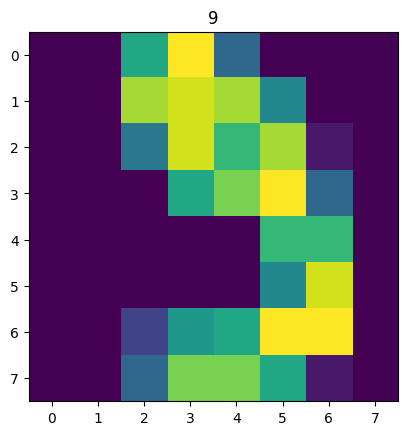

In [7]:
image=299
plt.imshow(gen_train[image].reshape(8,8))
plt.title('{}'.format(gen_y_train[image]))

In [8]:
for i in range(len(gen_train)):
  for j in [90,180,270]:
    rotated_im = imutils.rotate(gen_train[i].numpy().reshape(8,8), angle=j).reshape((1,64))
    gen_train = torch.cat((gen_train, torch.tensor(rotated_im)), 0)
    gen_y_train = torch.cat((gen_y_train, gen_y_train[i].reshape((1))), 0)

In [9]:
train_data = Data(gen_train)

Text(0.5, 1.0, '9')

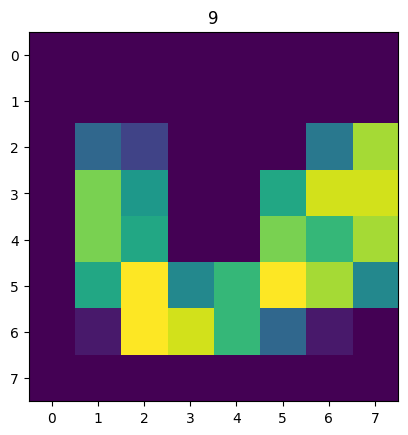

In [10]:
image=1199
plt.imshow(gen_train[image].reshape(8,8))
plt.title('{}'.format(gen_y_train[image]))

In [11]:
data_dim = 8*8

prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=512, num_flows=10)

train_loader = DataLoader(train_data, batch_size=250, shuffle=True)


In [12]:
epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%100 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))


Epoch :  1   -----------> Loss :  94.80754699707032
Epoch :  100   -----------> Loss :  61.446013641357425
Epoch :  200   -----------> Loss :  29.53692207336426
Epoch :  300   -----------> Loss :  -1.8321378707885743
Epoch :  400   -----------> Loss :  -30.541223526000977
Epoch :  500   -----------> Loss :  -55.979218292236325
Epoch :  600   -----------> Loss :  -69.96672210693359
Epoch :  700   -----------> Loss :  -90.53614196777343
Epoch :  800   -----------> Loss :  -102.97814178466797
Epoch :  900   -----------> Loss :  -108.70870056152344
Epoch :  1000   -----------> Loss :  -102.78408203125


In [13]:
test = prior.sample((50,))
test

tensor([[ 1.9680, -1.0753, -0.9861,  ..., -1.7824, -0.3571, -1.8173],
        [-0.7384, -2.4509,  1.8992,  ..., -0.3354,  1.9445,  0.5046],
        [-0.4140,  1.4073,  0.3589,  ..., -0.0519, -0.2337, -0.5597],
        ...,
        [ 0.6797,  0.5009, -2.5227,  ...,  0.4403, -0.2118,  1.0537],
        [ 1.0403, -0.4042, -0.0333,  ..., -0.1650,  0.5087,  2.8974],
        [ 0.7034, -1.9543, -0.0620,  ..., -1.3628, -0.7901,  0.2971]])

In [14]:

sonuc = model.f_inv(test)
sonuc


tensor([[-7.9306e-03, -4.0184e-02,  4.0157e-03,  ...,  1.0201e-01,
         -8.0626e-02, -1.6268e-02],
        [ 8.4068e-03,  2.0043e-02,  1.0515e-02,  ..., -8.9878e-02,
          4.5812e-02,  2.3199e-02],
        [ 7.6477e-03, -2.4747e-02,  9.7599e-02,  ..., -3.7186e-02,
         -5.1618e-02, -3.9438e-02],
        ...,
        [ 4.7008e-04,  4.4820e-02, -3.2829e-02,  ...,  8.9524e-01,
          7.7530e-01,  2.2131e-02],
        [ 3.6623e-03,  2.3206e-02,  1.9383e-01,  ...,  4.0315e-01,
          6.6045e-02,  2.0521e-02],
        [-9.7425e-04, -1.6807e-02,  1.0005e-01,  ...,  8.1706e-01,
          6.8502e-02,  3.3558e-02]], grad_fn=<MulBackward0>)

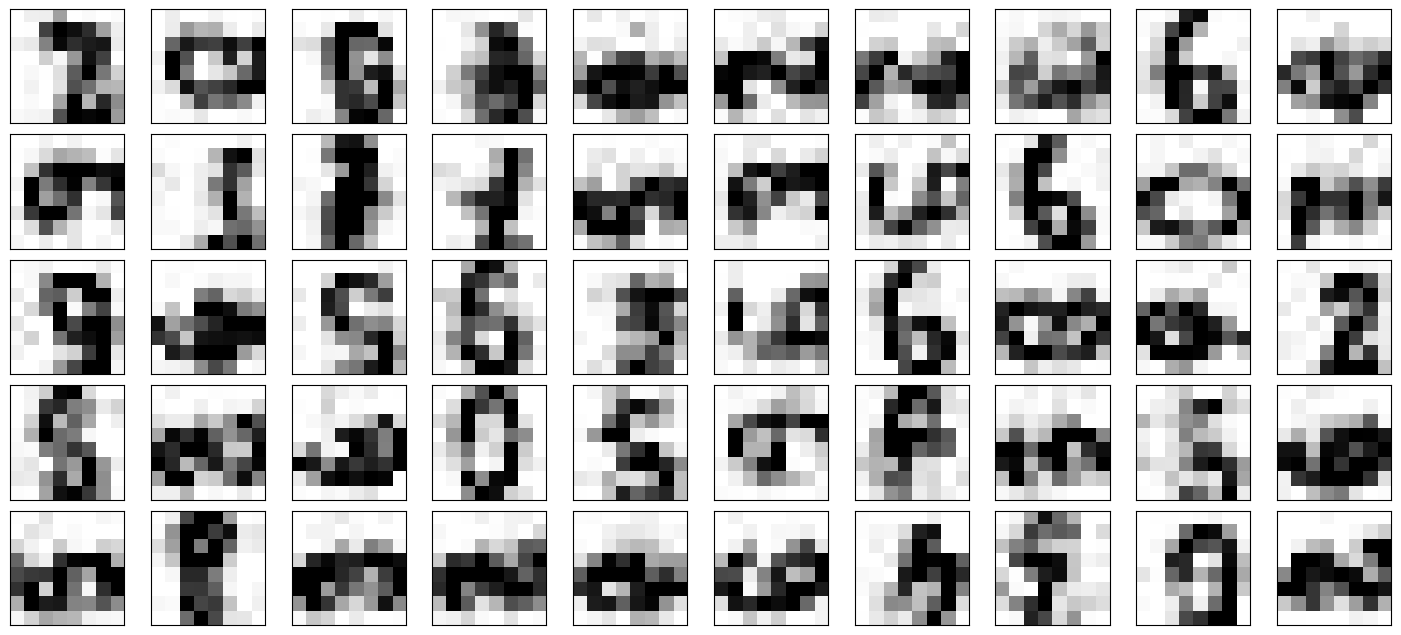

In [15]:
test = prior.sample((1797,))
sonuc = torch.nn.ReLU()(model.f_inv(test))

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
fig.show()

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
#pca.fit(sonuc)

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
#pca.fit(sonuc)

In [18]:
forward, logdet_j = model.forward(torch.tensor(gen_train))
backward = model.f_inv(forward)

<ipython-input-18-47850105f502>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  forward, logdet_j = model.forward(torch.tensor(gen_train))


In [19]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(backward.detach().numpy())          #sonuc.detach().numpy()
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1200, 2)


In [20]:
projected_raw = pca.fit_transform(gen_train)          #sonuc.detach().numpy()
print(digits.data.shape)
print(projected_raw.shape)

(1797, 64)
(1200, 2)


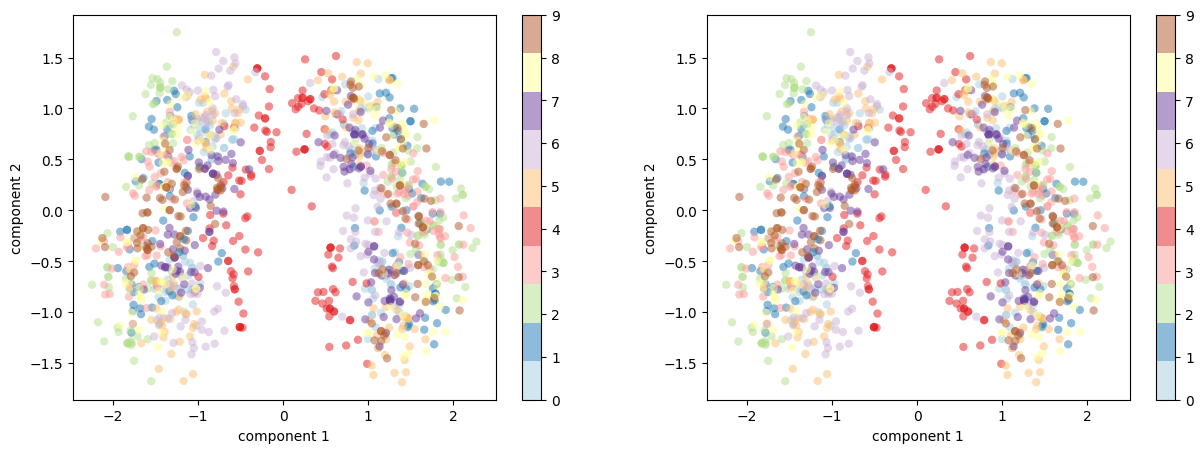

In [21]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1, 2, 1)
im1 = ax1.scatter(projected_raw[:, 0], projected_raw[:, 1],
            c=gen_y_train, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Paired', 10))
ax1.set_xlabel('component 1')
ax1.set_ylabel('component 2')
plt.colorbar(im1, ax=ax1)

ax2 = fig.add_subplot(1, 2, 2)
im2 = ax2.scatter(projected[:, 0], projected[:, 1],
            c=gen_y_train, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Paired', 10))
ax2.set_xlabel('component 1')
ax2.set_ylabel('component 2')
plt.colorbar(im2, ax=ax2)

plt.show()

In [32]:
gen_train[0].shape

torch.Size([64])

In [33]:
forward, logdet_j = model.forward(torch.tensor(gen_train[0]))
backward = model.f_inv(forward)

<ipython-input-33-a7f312b440e7>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  forward, logdet_j = model.forward(torch.tensor(gen_train[0]))


In [34]:
backward.shape

torch.Size([64, 64])

In [26]:
plt.imshow((backward).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))

ValueError: ignored